In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.text_cell_render ul li{font-size:12pt; line-height:30px;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [2]:
# ===============================
# 📌 기본 라이브러리
# ===============================
import pandas as pd
import numpy as np

# ===============================
# 📌 시각화 라이브러리
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 📌 경고 메시지 제거 (대용량 CSV 처리 시 깔끔)
# ===============================
import warnings
warnings.filterwarnings("ignore")

# ===============================
# 📌 한글 폰트 설정 (Windows)
# ===============================
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# ===============================
# 📌 CSV에서 불러올 컬럼 지정
# (불필요한 컬럼 제거 → 메모리 절약)
# ===============================
use_cols = [
    '인허가일자',
    '상세영업상태명',
    '폐업일자',
    '소재지전체주소',
    '도로명전체주소',
    '업태구분명',
    '좌표정보x(epsg5174)',
    '좌표정보y(epsg5174)'
]


In [4]:
import os

os.listdir("C:/aii/m4/data")

['6110000_서울특별시_07_24_04_P_일반음식점.csv']

In [5]:
# ===============================
# 📌 데이터 로드
# ===============================
df = pd.read_csv(
    "C:/aii/m4/data/6110000_서울특별시_07_24_04_P_일반음식점.csv",
    encoding="cp949",
    usecols=use_cols,
    low_memory=False
)

In [6]:
df.head()


,인허가일자,상세영업상태명,폐업일자,소재지전체주소,도로명전체주소,업태구분명,좌표정보x(epsg5174),좌표정보y(epsg5174)
0,2024-05-30,영업,NaN,서울특별시 강북구 수유동 229-46,"서울특별시 강북구 도봉로87길 11, 지하1층 (수유동)",기타,202125.400308,459553.074675
1,2025-05-02,영업,NaN,서울특별시 종로구 관훈동 155-2,"서울특별시 종로구 인사동길 49, 3층 4호 (관훈동)","외국음식전문점(인도,태국등)",198498.918633,452473.403750
2,2025-05-02,영업,NaN,서울특별시 종로구 관훈동 155-2,"서울특별시 종로구 인사동길 49, 4층 401호 (관훈동)",한식,198498.918633,452473.403750
3,2025-05-02,영업,NaN,서울특별시 종로구 인사동 241,"서울특별시 종로구 종로11길 9-10, 2층 (인사동)",기타,198625.513334,452075.105119
4,2024-05-31,영업,NaN,서울특별시 양천구 신월동 60-33,"서울특별시 양천구 화곡로 96, 1층 (신월동)",한식,185121.904558,448581.231912


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527872 entries, 0 to 527871
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   인허가일자            527872 non-null  object 
 1   상세영업상태명          527872 non-null  object 
 2   폐업일자             406206 non-null  object 
 3   소재지전체주소          527644 non-null  object 
 4   도로명전체주소          277927 non-null  object 
 5   업태구분명            527854 non-null  object 
 6   좌표정보x(epsg5174)  495424 non-null  float64
 7   좌표정보y(epsg5174)  495424 non-null  float64
dtypes: float64(2), object(6)
memory usage: 32.2+ MB


In [8]:
df.isna().sum()


인허가일자                   0
상세영업상태명                 0
폐업일자               121666
소재지전체주소               228
도로명전체주소            249945
업태구분명                  18
좌표정보x(epsg5174)     32448
좌표정보y(epsg5174)     32448
dtype: int64

In [9]:
# 소재지 주소가 있으면 우선 사용, 없으면 도로명 주소 사용
df['주소'] = df['소재지전체주소'].fillna(df['도로명전체주소'])


In [10]:
df['주소'].isna().sum()


0

In [11]:
# 주소 문자열에서 '○○구' 패턴 추출
df['구'] = df['주소'].str.extract(r'(서울특별시\s*)?(\w+구)')[1]
# 구 정보 없는 행 제거
df[['주소', '구']].head()

,주소,구
0,서울특별시 강북구 수유동 229-46,강북구
1,서울특별시 종로구 관훈동 155-2,종로구
2,서울특별시 종로구 관훈동 155-2,종로구
3,서울특별시 종로구 인사동 241,종로구
4,서울특별시 양천구 신월동 60-33,양천구


In [12]:
# '구' 결측치 제거
df['구'].isna().sum()
df = df[df['구'].notna()].copy()

In [13]:
# 서울특별시 데이터만 유지 (타 지역 자동 제거)
df = df[df['주소'].str.contains('서울', na=False)].copy()


In [14]:
# 문자열 → datetime 변환
df['인허가일자'] = pd.to_datetime(df['인허가일자'], errors='coerce')
df['폐업일자'] = pd.to_datetime(df['폐업일자'], errors='coerce')

# 인허가일자 없는 행 제거
df = df[df['인허가일자'].notna()].copy()

# ✅ 2015년 이후만 사용
df = df[df['인허가일자'] >= '2015-01-01'].copy()

# 좌표 결측치 제거
df = df[
    df['좌표정보x(epsg5174)'].notna() &
    df['좌표정보y(epsg5174)'].notna()
].copy()

In [15]:
# 창업월, 창업연도
df['창업월'] = df['인허가일자'].dt.month
df['창업연도'] = df['인허가일자'].dt.year


In [16]:
# 영업 기간 계산 
df['영업일수'] = (
    df['폐업일자'].fillna(pd.Timestamp.today())
    - df['인허가일자']
).dt.days

In [17]:
#3년 이내 폐업 여부
df['폐업_3년이내'] = (
    (df['폐업일자'].notna()) &
    (df['영업일수'] <= 365 * 3)
).astype(int)

In [18]:
#문자열의 앞뒤 공백을 제거
df['업태'] = df['업태구분명'].str.strip()


In [19]:
df['업태'].value_counts()


한식                 51988
기타                 38295
경양식                10919
호프/통닭               9681
일식                  8683
분식                  7272
중국식                 5180
외국음식전문점(인도,태국등)     3387
식육(숯불구이)            1392
정종/대포집/소주방          1380
김밥(도시락)              629
횟집                   615
뷔페식                  509
감성주점                 493
까페                   440
패밀리레스트랑              369
라이브카페                297
냉면집                  296
통닭(치킨)               196
출장조리                 122
키즈카페                  91
패스트푸드                 63
탕류(보신용)               61
복어취급                  26
기타 휴게음식점               2
전통찻집                   1
식품소분업                  1
Name: 업태, dtype: int64

In [20]:
# 업태 빈도
type_counts = df['업태'].value_counts()

# 10개 이하 업태 목록
rare_types = type_counts[type_counts <= 10].index

rare_types

Index(['기타 휴게음식점', '전통찻집', '식품소분업'], dtype='object')

In [21]:
# 표본 10개 이하 업태 → 기타로 통합
df['업태_정리'] = df['업태'].replace(rare_types, '기타')

In [22]:
# ===============================
#  업태 그룹화 함수
# ===============================
def map_category(x):
    if pd.isna(x):
        return '기타'

    if x in ['한식', '탕류(보신용)', '냉면집']:
        return '한식'

    if x in ['분식', '김밥(도시락)', '패스트푸드']:
        return '분식/간편식'

    if x in ['경양식', '패밀리레스트랑', '외국음식전문점(인도,태국등)', '뷔페식']:
        return '양식/외식'

    if x in ['중국식', '일식']:
        return '중·일식'

    if x in ['호프/통닭', '정종/대포집/소주방', '통닭(치킨)', '감성주점', '간이주점', '룸살롱']:
        return '주점/치킨'

    if x in ['까페', '커피숍', '전통찻집', '라이브카페', '다방', '키즈카페']:
        return '카페'

    return '기타'

In [23]:
# 업태 그룹 컬럼 생성
df['업태_그룹'] = df['업태'].apply(map_category)
df['업태_그룹'].value_counts()

한식        52345
기타        40455
양식/외식     15184
중·일식      13863
주점/치킨     11750
분식/간편식     7964
카페          829
Name: 업태_그룹, dtype: int64

In [24]:
# 업태 그룹별 3년 이내 폐업률 (%)로 출력
(
    df.groupby('업태_그룹')['폐업_3년이내']
      .mean()
      .mul(100)
      .round(1)
      .sort_values()
)


업태_그룹
중·일식      27.5
카페        30.4
양식/외식     30.5
주점/치킨     31.2
한식        31.8
기타        36.9
분식/간편식    37.3
Name: 폐업_3년이내, dtype: float64

In [25]:
# 구별 폐업률
gu_rate = (
    df.groupby('구')['폐업_3년이내']
    .mean()
    .sort_values(ascending=False)
)

gu_rate.mul(100).round(1).head(10)


구
양천구    38.6
관악구    38.2
강남구    38.1
강북구    36.8
구로구    35.8
강동구    35.3
노원구    35.1
은평구    34.5
송파구    34.2
강서구    33.9
Name: 폐업_3년이내, dtype: float64

In [26]:
# ===============================
#  구 × 업태 그룹 폐업률 Pivot
# ===============================
pivot_gu_type = df.pivot_table(
    values='폐업_3년이내',
    index='구',
    columns='업태_그룹',
    aggfunc='mean'
)


In [27]:
pivot_gu_type_pct = pivot_gu_type.mul(100).round(1)
pivot_gu_type_pct

업태_그룹,기타,분식/간편식,양식/외식,주점/치킨,중·일식,카페,한식
구,,,,,,,
강남구,44.6,42.5,34.9,34.7,29.6,34.1,36.9
강동구,36.6,41.2,31.0,33.9,27.8,45.0,36.1
강북구,42.3,38.6,23.9,34.9,31.1,21.4,32.7
강서구,29.7,34.8,35.3,30.7,32.1,15.4,35.4
관악구,33.8,39.6,39.9,40.1,35.1,35.1,39.1
광진구,31.1,41.7,35.4,31.5,28.9,32.0,33.0
구로구,42.0,36.5,30.5,29.4,29.1,33.3,37.8
금천구,28.1,37.8,30.6,26.3,28.0,20.0,31.5
노원구,43.4,35.0,32.5,34.7,25.8,27.6,32.6


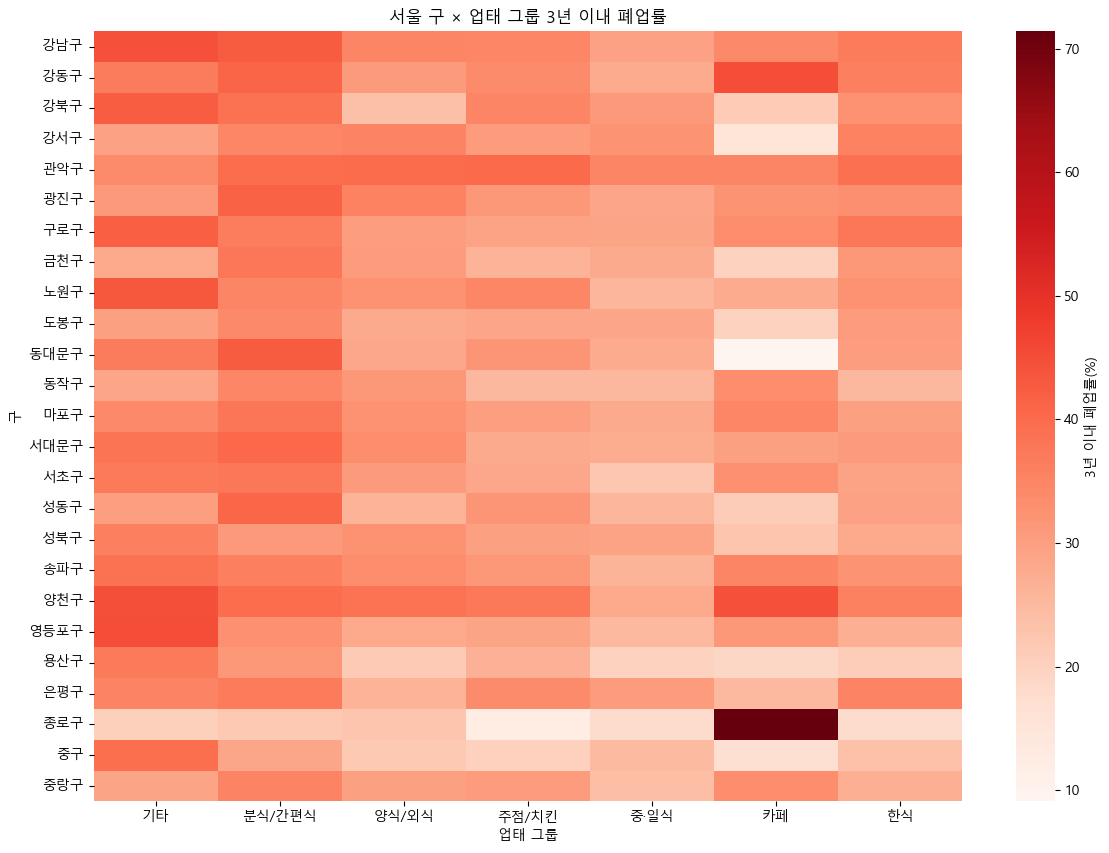

In [28]:
# ===============================
#  히트맵 시각화
# ===============================
plt.figure(figsize=(14,10))
sns.heatmap(
    pivot_gu_type_pct,
    cmap='Reds',
    annot=False,
    cbar_kws={'label': '3년 이내 폐업률(%)'}
)
plt.title('서울 구 × 업태 그룹 3년 이내 폐업률')
plt.xlabel('업태 그룹')
plt.ylabel('구')
plt.show()


In [29]:
# ===============================
#  위험 조합 TOP 추출
# ===============================
risk_table = pivot_gu_type_pct.stack().reset_index()
risk_table.columns = ['구', '업태_그룹', '폐업률']
risk_table.sort_values('폐업률', ascending=False).head(10)

,구,업태_그룹,폐업률
159,종로구,카페,71.4
12,강동구,카페,45.0
133,영등포구,기타,44.9
126,양천구,기타,44.8
0,강남구,기타,44.6
131,양천구,카페,44.4
56,노원구,기타,43.4
71,동대문구,분식/간편식,42.9
1,강남구,분식/간편식,42.5
14,강북구,기타,42.3


In [30]:
# ===============================
#  지도 시각화용 라이브러리 아나콘다에 설치.
#  아나콘다 프롬프트에서
#  conda install -c conda-forge geopandas 
# ===============================

import geopandas as gpd
gpd.__version__


'0.12.0'

In [31]:
gu_rate_map = (
    df.groupby('구')['폐업_3년이내']
      .mean()
      .mul(100)
      .round(1)
      .reset_index()
)

gu_rate_map.sort_values('폐업_3년이내', ascending=False).head()


,구,폐업_3년이내
18,양천구,38.6
4,관악구,38.2
0,강남구,38.1
2,강북구,36.8
6,구로구,35.8


In [32]:
seoul_map = gpd.read_file(
    "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"
)

seoul_map.head()


,code,name,name_eng,base_year,geometry
0,11250,강동구,Gangdong-gu,2013,"POLYGON ((127.11520 37.55753, 127.11880 37.557..."
1,11240,송파구,Songpa-gu,2013,"POLYGON ((127.06907 37.52228, 127.07496 37.520..."
2,11230,강남구,Gangnam-gu,2013,"POLYGON ((127.05867 37.52630, 127.06907 37.522..."
3,11220,서초구,Seocho-gu,2013,"POLYGON ((127.01397 37.52504, 127.01918 37.520..."
4,11210,관악구,Gwanak-gu,2013,"POLYGON ((126.98368 37.47386, 126.98464 37.469..."


In [33]:
# 지도 쪽 구 이름 컬럼 통일
seoul_map['구'] = seoul_map['name']

# merge
map_df = seoul_map.merge(
    gu_rate_map,
    on='구',
    how='left'
)

map_df

,code,name,name_eng,base_year,geometry,구,폐업_3년이내
0,11250,강동구,Gangdong-gu,2013,"POLYGON ((127.11520 37.55753, 127.11880 37.557...",강동구,35.3
1,11240,송파구,Songpa-gu,2013,"POLYGON ((127.06907 37.52228, 127.07496 37.520...",송파구,34.2
2,11230,강남구,Gangnam-gu,2013,"POLYGON ((127.05867 37.52630, 127.06907 37.522...",강남구,38.1
3,11220,서초구,Seocho-gu,2013,"POLYGON ((127.01397 37.52504, 127.01918 37.520...",서초구,31.8
4,11210,관악구,Gwanak-gu,2013,"POLYGON ((126.98368 37.47386, 126.98464 37.469...",관악구,38.2
5,11200,동작구,Dongjak-gu,2013,"POLYGON ((126.98224 37.50931, 126.98242 37.501...",동작구,27.6
6,11190,영등포구,Yeongdeungpo-gu,2013,"POLYGON ((126.89185 37.54737, 126.90281 37.541...",영등포구,32.2
7,11180,금천구,Geumcheon-gu,2013,"POLYGON ((126.90156 37.47754, 126.90277 37.476...",금천구,30.0
8,11170,구로구,Guro-gu,2013,"POLYGON ((126.82688 37.50549, 126.83122 37.505...",구로구,35.8
9,11160,강서구,Gangseo-gu,2013,"POLYGON ((126.85984 37.57185, 126.85950 37.568...",강서구,33.9


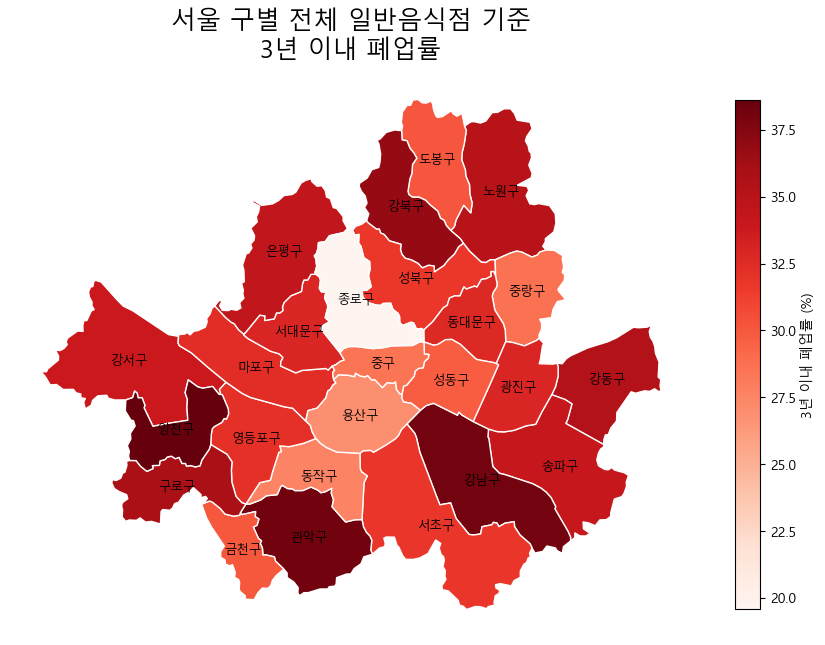

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))

# 1️⃣ 지도 색칠
map_df.plot(
    column='폐업_3년이내',
    cmap='Reds',
    linewidth=1,
    ax=ax,
    edgecolor='white',
    legend=True,
    legend_kwds={
        'label': '3년 이내 폐업률 (%)',
        'shrink': 0.6
    }
)

# 2️⃣ 구 이름 표시 (centroid 사용)
for idx, row in map_df.iterrows():
    if row['geometry'] is not None:
        x = row['geometry'].centroid.x
        y = row['geometry'].centroid.y
        ax.text(
            x, y,
            row['구'],
            fontsize=9,
            ha='center',
            va='center',
            color='black'
        )

# 3️⃣ 제목
ax.set_title(
    '서울 구별 전체 일반음식점 기준\n3년 이내 폐업률',
    fontsize=18,
    pad=12
)

ax.axis('off')
plt.show()


In [35]:
df['생존_3년이상'] = (
    (df['폐업일자'].isna()) &
    (df['영업일수'] >= 365 * 3)
)
df['생존_3년이상'].value_counts()

False    100545
True      41845
Name: 생존_3년이상, dtype: int64

In [36]:
df['상태'] = '기타'

df.loc[df['폐업_3년이내'] == 1, '상태'] = '폐업(3년 이내)'
df.loc[df['생존_3년이상'] == True, '상태'] = '3년 이상 영업중'


In [39]:
from shapely.geometry import Point

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=[
        Point(xy) for xy in zip(
            df['좌표정보x(epsg5174)'],
            df['좌표정보y(epsg5174)']
        )
    ],
    crs="EPSG:5174"
)

gdf_points.head()


,인허가일자,상세영업상태명,폐업일자,소재지전체주소,도로명전체주소,업태구분명,좌표정보x(epsg5174),좌표정보y(epsg5174),주소,구,창업월,창업연도,영업일수,폐업_3년이내,업태,업태_정리,업태_그룹,생존_3년이상,상태,geometry
0,2024-05-30,영업,NaT,서울특별시 강북구 수유동 229-46,"서울특별시 강북구 도봉로87길 11, 지하1층 (수유동)",기타,202125.400308,459553.074675,서울특별시 강북구 수유동 229-46,강북구,5,2024,570,0,기타,기타,기타,False,기타,POINT (202125.400 459553.075)
1,2025-05-02,영업,NaT,서울특별시 종로구 관훈동 155-2,"서울특별시 종로구 인사동길 49, 3층 4호 (관훈동)","외국음식전문점(인도,태국등)",198498.918633,452473.403750,서울특별시 종로구 관훈동 155-2,종로구,5,2025,233,0,"외국음식전문점(인도,태국등)","외국음식전문점(인도,태국등)",양식/외식,False,기타,POINT (198498.919 452473.404)
2,2025-05-02,영업,NaT,서울특별시 종로구 관훈동 155-2,"서울특별시 종로구 인사동길 49, 4층 401호 (관훈동)",한식,198498.918633,452473.403750,서울특별시 종로구 관훈동 155-2,종로구,5,2025,233,0,한식,한식,한식,False,기타,POINT (198498.919 452473.404)
3,2025-05-02,영업,NaT,서울특별시 종로구 인사동 241,"서울특별시 종로구 종로11길 9-10, 2층 (인사동)",기타,198625.513334,452075.105119,서울특별시 종로구 인사동 241,종로구,5,2025,233,0,기타,기타,기타,False,기타,POINT (198625.513 452075.105)
4,2024-05-31,영업,NaT,서울특별시 양천구 신월동 60-33,"서울특별시 양천구 화곡로 96, 1층 (신월동)",한식,185121.904558,448581.231912,서울특별시 양천구 신월동 60-33,양천구,5,2024,569,0,한식,한식,한식,False,기타,POINT (185121.905 448581.232)


In [40]:
gdf_points = gpd.GeoDataFrame(
    df[df['상태'].isin(['폐업(3년 이내)', '3년 이상 영업중'])],
    geometry=[
        Point(xy) for xy in zip(
            df.loc[df['상태'].isin(['폐업(3년 이내)', '3년 이상 영업중']), '좌표정보x(epsg5174)'],
            df.loc[df['상태'].isin(['폐업(3년 이내)', '3년 이상 영업중']), '좌표정보y(epsg5174)']
        )
    ],
    crs="EPSG:5174"
)


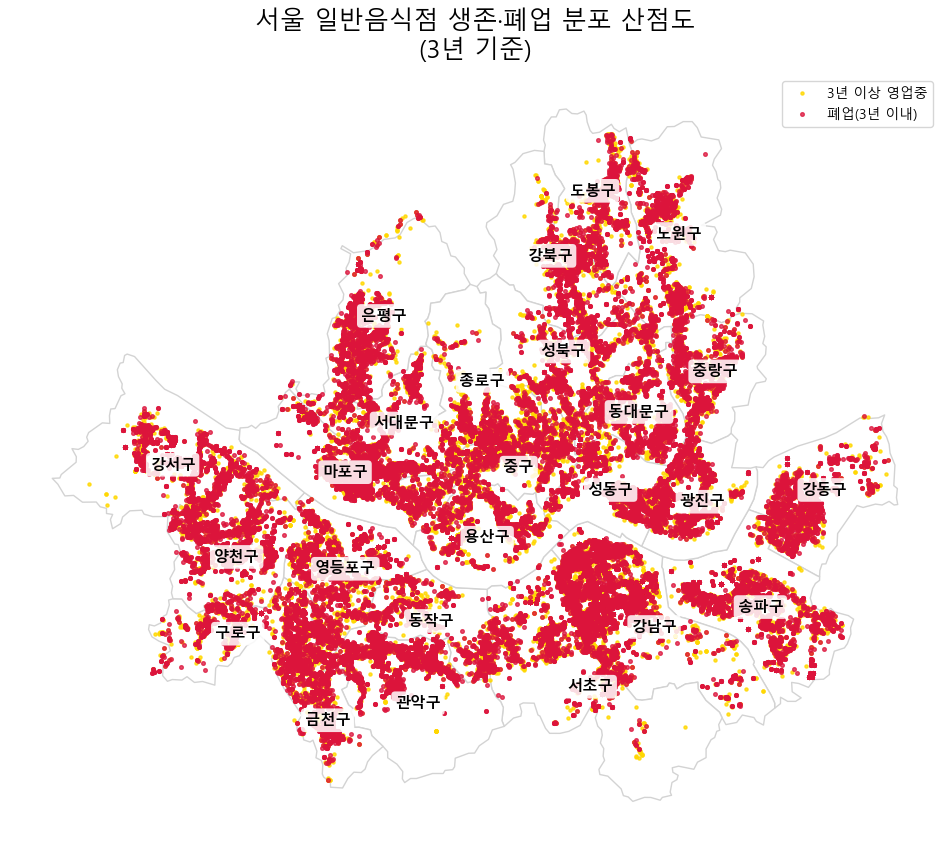

In [41]:
# 서울 지도 좌표계 변환
seoul_map_5174 = seoul_map.to_crs(epsg=5174)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 1️⃣ 배경 지도
seoul_map_5174.plot(
    ax=ax,
    color='white',
    edgecolor='lightgray',
    linewidth=1
)

# 2️⃣ 기타 영업중 (배경)
gdf_points[gdf_points['상태'] == '기타'].plot(
    ax=ax,
    markersize=2,
    color='lightgray',
    alpha=0.2,
    label='기타 영업중'
)

# 3️⃣ 🟡 3년 이상 영업중 (생존)
gdf_points[gdf_points['상태'] == '3년 이상 영업중'].plot(
    ax=ax,
    markersize=5,
    color='gold',
    alpha=0.8,
    label='3년 이상 영업중'
)

# 4️⃣ 🔴 폐업 (3년 이내)
gdf_points[gdf_points['상태'] == '폐업(3년 이내)'].plot(
    ax=ax,
    markersize=7,
    color='crimson',
    alpha=0.75,
    label='폐업(3년 이내)'
)

# 5️⃣ 구 이름 표시 (centroid)
for idx, row in seoul_map_5174.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    ax.text(
        x, y,
        row['구'],
        fontsize=11,              # 글자 키움
        fontweight='bold',        # 굵게
        ha='center',
        va='center',
        color='black',
        bbox=dict(                # ⭐ 핵심
            boxstyle='round,pad=0.25',
            facecolor='white',
            edgecolor='none',
            alpha=0.85
        )
    )

# 6️⃣ 제목
ax.set_title(
    '서울 일반음식점 생존·폐업 분포 산점도\n(3년 기준)',
    fontsize=18,
    pad=12
)

ax.legend()
ax.axis('off')
plt.show()


# 시계열데이터

In [43]:
# 폐업일자와 개업일자를 구분

open_df = df[['인허가일자']].dropna().copy()
open_df['날짜'] = open_df['인허가일자']
open_df['개업수'] = 1          

close_df = df[['폐업일자']].dropna().copy()
close_df['날짜'] = close_df['폐업일자']
close_df['폐업수'] = 1         


In [44]:
# 하루단위는 변동이 너무 크기 때문에 연월로 묶어서 분석처리 
# 예)  period 함수: 2021-03-01 -> 2021-03 이런식으로 바꿔준다
open_df['연월'] = open_df['날짜'].dt.to_period('M')
close_df['연월'] = close_df['날짜'].dt.to_period('M') 


In [45]:
# 그 년도에 개업수와 폐업수를 구분한다 

open_ts = (
    open_df.groupby('연월')['개업수'] # 같은 연, 월에 발생한 개업 사건들을 하나의 그룹으로 묶는다
    .sum() # count랑 같은 개념인데 나중에 가중치줄 때 더 편하다고한다 뜻은 count랑 비슷한의미로 위에 연월 그룹에 개업수를 모두 더한다
    .reset_index() # 다시 일반 컬럼으로 형태 변환
)

close_ts = (
    close_df.groupby('연월')['폐업수']
    .sum()
    .reset_index()
)


In [46]:
ts_df = (
    pd.merge(open_ts, close_ts, on='연월', how='outer') # merge는 합치는 '연월'(key)을 기준으로 열을 붙인다 1 | 2 이런식으로 표시 
      .fillna(0) #결측치는 0으로 대체한다
) 


In [47]:
ts_df['폐업률'] = ts_df['폐업수'] / ts_df['개업수']
ts_df['연월'] = ts_df['연월'].dt.to_timestamp()
            # 월 폐업 건수
# 폐업율 = --------------------
            # 월 개업 건수         예시 개업:100 / 폐업:80 이면 폐업률 0.80 %확률

In [48]:
ts_df

,연월,개업수,폐업수,폐업률
0,2015-01-01,717,4,0.005579
1,2015-02-01,751,4,0.005326
2,2015-03-01,1090,17,0.015596
3,2015-04-01,1126,21,0.018650
4,2015-05-01,919,16,0.017410
...,...,...,...,...
126,2025-07-01,1158,986,0.851468
127,2025-08-01,1166,966,0.828473
128,2025-09-01,1405,1310,0.932384
129,2025-10-01,1206,1084,0.898839


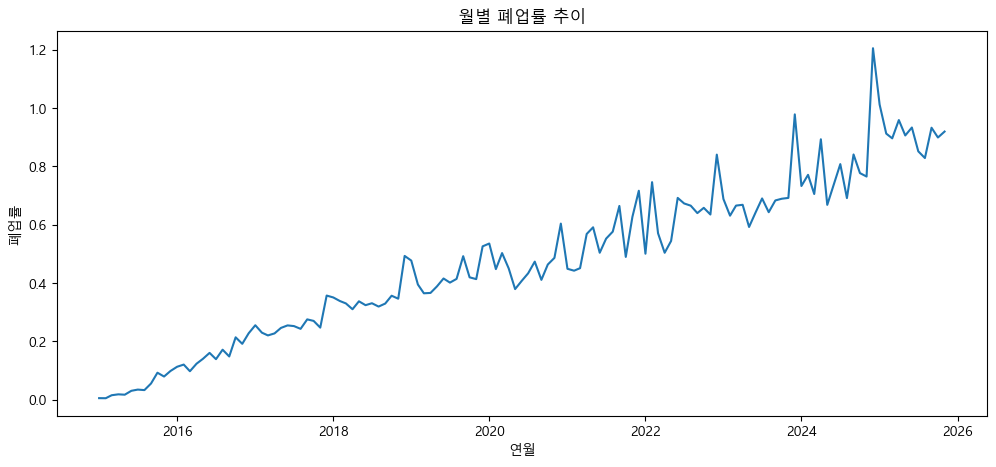

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(ts_df["연월"], ts_df["폐업률"])
plt.title("월별 폐업률 추이")
plt.xlabel("연월")
plt.ylabel("폐업률")
plt.show()


In [52]:
ts_df["time_index"] = range(len(ts_df))


In [53]:
from sklearn.linear_model import LinearRegression

X = ts_df[["time_index"]]
y = ts_df["폐업률"]

model = LinearRegression()
model.fit(X, y)

ts_df["pred"] = model.predict(X)


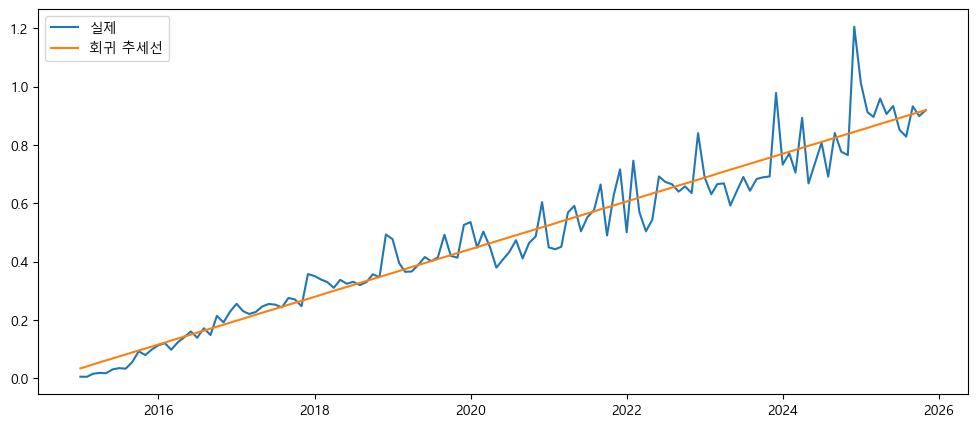

In [54]:
plt.figure(figsize=(12,5))
plt.plot(ts_df["연월"], y, label="실제")
plt.plot(ts_df["연월"], ts_df["pred"], label="회귀 추세선")
plt.legend()
plt.show()


In [62]:
# 시간이 지날 수록 폐업률이 증가하나?

ts_df = ts_df.sort_values('연월')

ts_df['t'] = np.arange(len(ts_df))

import statsmodels.api as sm

X = sm.add_constant(ts_df['t'])
y = ts_df['폐업률']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    폐업률   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     1823.
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           5.75e-78
Time:                        17:31:08   Log-Likelihood:                 165.31
No. Observations:                 131   AIC:                            -326.6
Df Residuals:                     129   BIC:                            -320.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0341      0.012      2.845      0.0

In [56]:
# 개업이 많았던 달은 폐업도 많았는가?
X = ts_df[['개업수']]
X = sm.add_constant(X)
y = ts_df['폐업수']

model = sm.OLS(y, X).fit()
print(model.summary())
 

                            OLS Regression Results                            
Dep. Variable:                    폐업수   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     76.40
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           1.06e-14
Time:                        16:43:26   Log-Likelihood:                -912.61
No. Observations:                 131   AIC:                             1829.
Df Residuals:                     129   BIC:                             1835.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -778.9780    152.170     -5.119      0.0

In [61]:
# 지난달 개업이 이번달 폐업에 영향이 있나?
ts_df['개업수_lag1'] = ts_df['개업수'].shift(1)

X = ts_df[['개업수_lag1']]
X = sm.add_constant(X)
y = ts_df['폐업수']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    폐업수   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     60.52
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           2.12e-12
Time:                        16:49:38   Log-Likelihood:                -909.84
No. Observations:                 130   AIC:                             1824.
Df Residuals:                     128   BIC:                             1829.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -668.8599    157.202     -4.255      0.0

In [58]:
# 계절성 반영(월 더미)
ts_df['month'] = ts_df['연월'].dt.month
month_dummies = pd.get_dummies(ts_df['month'], drop_first=True)

X = pd.concat([ts_df[['t']], month_dummies], axis=1)
X = sm.add_constant(X)
y = ts_df['폐업률']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    폐업률   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     214.9
Date:                Sun, 21 Dec 2025   Prob (F-statistic):           4.04e-74
Time:                        16:43:36   Log-Likelihood:                 192.32
No. Observations:                 131   AIC:                            -358.6
Df Residuals:                     118   BIC:                            -321.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0557      0.020      2.856      0.0